<a href="https://colab.research.google.com/github/butoialexandra/Determining-country-specific-engagement-in-climate-change-policies/blob/main/3_Topic_Modeling_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modeling

Code adapted from [here](https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know?utm_source=datacamp&utm_medium=post&utm_campaign=blog-pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know)


Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


Check you're in the right place

In [2]:
!pwd

/content


In [3]:
%cd /content/drive/My\ Drive/

/content/drive/My Drive


Download these libraries if haven't done already

In [ ]:
!python -m spacy download en
!pip install pyLDAvis==3.2.1

Imports

In [33]:
import re
import numpy as np
import pandas as pd
import glob
from pprint import pprint
from tqdm import tqdm

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.porter import PorterStemmer

import spacy

import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Load data

In [7]:
df = pd.read_csv("./data.csv") 

In [8]:
df.head(5)

,Document,NDC
0,../txts/CPV_Cabo-Verde_First_NDC_English_Parag...,Cabo Verde is committed to implement the Susta...
1,../txts/LKA_Sri-Lanka_First_NDC_English_Paragr...,The means of implementation of NDCs of Sri Lan...
2,../txts/RWA_Rwanda_First_NDC_English_Paragraph...,This updated NDC updates and strengthens the f...
3,../txts/NER_Niger_First_NDC_Translation_Englis...,to use climate financing and benefit from the ...
4,../txts/GMB_Gambia_First_NDC_English_Paragraph...,Gambia Watershed by a) Improving disaster prep...


Some processing

In [10]:
df['NDC_processed'] = df['NDC'].apply(lambda x: re.sub('[(),\\.!?0-9]', '', x))
df['NDC_processed'] = df['NDC_processed'].apply(lambda x: x.lower())
df['NDC_processed'] = df['NDC_processed'].apply(lambda x: x.strip())
df['NDC_processed'] = df['NDC_processed'].apply(lambda x: re.sub(' +', ' ', x))
df = df[df['NDC_processed'].apply(lambda x: len(x) > 100)]

In [68]:
df = df.reset_index(drop=True)
df

,Document,NDC,NDC_processed
0,../txts/CPV_Cabo-Verde_First_NDC_English_Parag...,Cabo Verde is committed to implement the Susta...,cabo verde is committed to implement the susta...
1,../txts/RWA_Rwanda_First_NDC_English_Paragraph...,This updated NDC updates and strengthens the f...,this updated ndc updates and strengthens the f...
2,../txts/GMB_Gambia_First_NDC_English_Paragraph...,Gambia Watershed by a) Improving disaster prep...,gambia watershed by a improving disaster prepa...
3,../txts/JOR_Jordan_First_NDC_English_Paragraph...,The estimated cost to reach the 14 target is t...,the estimated cost to reach the target is tota...
4,../txts/FSM_Micronesia_First_NDC_English_Parag...,"Moreover, national efforts to implement INDC i...",moreover national efforts to implement indc in...
...,...,...,...
10817,../txts/KHM_Cambodia_First_NDC_English_Paragra...,conducting surveillance and research on waterb...,conducting surveillance and research on waterb...
10818,../txts/URY_Uruguay_First_NDC_Translation_Engl...,The above chart contains a not exhaustive list...,the above chart contains a not exhaustive list...
10819,../txts/MAR_Morocco_First_NDC_Translation_Engl...,"principles to be respected by the state, local...",principles to be respected by the state local ...
10820,../txts/LKA_Sri-Lanka_First_NDC_English_Paragr...,Integrated planning is the key means of implem...,integrated planning is the key means of implem...


In [ ]:
df.to_csv("data_processed.csv")

Process data for LDA

In [23]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# def make_trigrams(texts):
#     return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        print([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def stemming(texts):
  p = PorterStemmer()
  return [p.stem_documents(text) for text in texts]

In [13]:
ndcs = df.NDC_processed.values.tolist()
words = list(sent_to_words(ndcs))

bigram = gensim.models.Phrases(words, min_count=5, threshold=100)
# trigram = gensim.models.Phrases(bigram[words], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [27]:
data_words_nostops = remove_stopwords(words)

#data_words_bigrams = make_bigrams(data_words_nostops)

#nlp = spacy.load('en', disable=['parser', 'ner'])

#data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

data_stemmed = stemming(data_words_nostops)

data_words_bigrams = make_bigrams(data_stemmed)

In [ ]:
data_words_bigrams

Make corpus

In [40]:
id2word = corpora.Dictionary(data_words_bigrams)
texts = data_words_bigrams
corpus = [id2word.doc2bow(text) for text in texts]

Train gensim LDA model with 10 topics

In [41]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [42]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.026*"island" + 0.025*"increas" + 0.024*"flood" + 0.021*"temperatur" + '
  '0.020*"rise" + 0.018*"drought" + 0.017*"countri" + 0.016*"affect" + '
  '0.014*"rainfal" + 0.013*"result"'),
 (1,
  '0.091*"emiss" + 0.036*"ghg" + 0.030*"sector" + 0.030*"project" + '
  '0.027*"reduct" + 0.021*"year" + 0.019*"growth" + 0.018*"carbon" + '
  '0.016*"reduc" + 0.016*"estim"'),
 (2,
  '0.038*"nation" + 0.025*"contribut" + 0.018*"target" + 0.016*"indc" + '
  '0.015*"ndc" + 0.014*"achiev" + 0.013*"countri" + 0.011*"identifi" + '
  '0.011*"commun" + 0.011*"inform"'),
 (3,
  '0.046*"forest" + 0.045*"area" + 0.029*"natur" + 0.029*"popul" + '
  '0.025*"protect" + 0.022*"econom" + 0.018*"high" + 0.015*"peopl" + '
  '0.014*"social" + 0.014*"resourc"'),
 (4,
  '0.113*"us" + 0.041*"land" + 0.031*"data" + 0.024*"forestri" + 0.020*"ipcc" '
  '+ 0.014*"valu" + 0.014*"potenti" + 0.014*"livestock" + 0.013*"includ" + '
  '0.013*"decreas"'),
 (5,
  '0.053*"develop" + 0.037*"adapt" + 0.030*"plan" + 0.029*"im

Check perplexity and coherence score

In [43]:
print('Perplexity: {}'.format(lda_model.log_perplexity(corpus)))

coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: {}'.format(coherence_lda))

Perplexity: -7.249567337190181
Coherence Score: 0.5278614753593946


Visualize topics

In [44]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.252566  0.134054       1        1  24.434688
2     -0.259154 -0.006692       2        1  18.030375
1     -0.143360 -0.113570       3        1  11.962420
6      0.113938 -0.030742       4        1   9.398393
3     -0.052036 -0.104505       5        1   7.708953
8      0.087308  0.141002       6        1   7.116051
9      0.094689  0.239372       7        1   6.857648
0      0.053047 -0.247149       8        1   5.663568
4      0.157123  0.127449       9        1   5.651313
7      0.201010 -0.139219      10        1   3.176592, topic_info=            Term         Freq        Total Category  logprob  loglift
110       climat  6642.000000  6642.000000  Default  30.0000  30.0000
109        chang  5165.000000  5165.000000  Default  29.0000  29.0000
181        emiss  3946.000000  3946.000000  Default  28.0000  28.0000
9         energi  2978.000000  2978.000000  Default  27.0000  27.0000
195           us  2327.000000  2327.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1395  world_bank    90.113683    91.032644  Topic10  -4.8516   3.4392
1325     citizen    87.845074    88.763992  Topic10  -4.8771   3.4390
1476  multilater    86.656866    87.575959  Topic10  -4.8908   3.4388
1582       mobil    83.879530    84.798424  Topic10  -4.9233   3.4385
1601       usual    83.036002    83.954875  Topic10  -4.9334   3.4384

[455 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
752       2  0.999375  achiev
381       4  0.993290     act
481       1  0.997917  action
481       2  0.001957  action
219       1  0.939329   activ
...     ...       ...     ...
218       3  0.862081   would
218      10  0.134350   would
177       3  0.891739    year
177       8  0.107522    year
1155      8  0.990799    zone

[544 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 2, 7, 4, 9, 10, 1, 5, 8])

Train LDA using Mallet

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

mallet_path = 'mallet-2.0.8/bin/mallet'

Train LDA with Mallet

In [45]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)
pprint(ldamallet.show_topics(formatted=False))

coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('Coherence Score: {}'.format(coherence_ldamallet))

[(0,
  [('emiss', 0.11753863604140083),
   ('ghg', 0.04366936055579186),
   ('reduct', 0.04012476960158798),
   ('target', 0.03612647100524599),
   ('contribut', 0.031731178222033175),
   ('global', 0.02841344108889834),
   ('achiev', 0.020813838083085213),
   ('reduc', 0.02047355735148164),
   ('carbon', 0.019481071884304552),
   ('level', 0.017779668226286686)]),
 (1,
  [('countri', 0.038574556349389263),
   ('year', 0.03252477529384651),
   ('econom', 0.031689329338557275),
   ('increas', 0.023104401935929938),
   ('growth', 0.021491126987785204),
   ('sector', 0.020655681032495966),
   ('economi', 0.020165936851809174),
   ('project', 0.0198490435584236),
   ('popul', 0.018322194053929475),
   ('million', 0.018293385572712605)]),
 (2,
  [('implement', 0.059480979062223535),
   ('mitig', 0.04423473901503981),
   ('support', 0.043969330580949574),
   ('measur', 0.031111766440578),
   ('intern', 0.030521969920377468),
   ('technolog', 0.030374520790327337),
   ('develop', 0.0278973754

Converd Mallet model to gensim in order to be able to visualize topics with pyLDAvis

In [46]:
def convertldaGenToldaMallet(mallet_model):
    model_gensim = gensim.models.ldamodel.LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0,
    )
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

mallet_model = convertldaGenToldaMallet(ldamallet)

In [47]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(mallet_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:236: RuntimeWarning: divide by zero encountered in log
  log_1 = np.log(pd.eval("(topic_given_term.T / topic_proportion)"))
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:259: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(pd.eval("topic_term_dists / term_proportion")).astype("float64")
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:260: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists).astype("float64")


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.081704 -0.285157       1        1  10.635601
4      0.320781  0.003007       2        1  10.558587
1      0.110540  0.244937       3        1  10.368494
0     -0.154789  0.148623       4        1  10.105029
2     -0.125615 -0.081780       5        1   9.915953
8     -0.221458 -0.064311       6        1   9.863094
9      0.089899 -0.219766       7        1   9.710766
7      0.112086  0.068374       8        1   9.678827
6      0.004856  0.208232       9        1   9.633441
5     -0.218003 -0.022159      10        1   9.530208, topic_info=          Term         Freq        Total Category  logprob  loglift
181      emiss  4311.000000  4311.000000  Default  30.0000  30.0000
110     climat  6882.000000  6882.000000  Default  29.0000  29.0000
109      chang  5287.000000  5287.000000  Default  28.0000  28.0000
9       energi  3385.000000  3385.000000  Default  27.0000  27.0000
20       adapt  3466.000000  3466.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
395     commun   525.251337  1386.398884  Topic10  -4.1875   1.3801
235     includ   632.381819  2221.844761  Topic10  -4.0019   1.0941
991       base   411.880255   896.044262  Topic10  -4.4306   1.5734
44         ndc   455.564517  1339.213314  Topic10  -4.3298   1.2724
402  greenhous   303.709678   766.541504  Topic10  -4.7353   1.4249

[708 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
347       6  1.005528   academ
100       2  0.028683   accord
100       4  0.118318   accord
100      10  0.853325   accord
80        1  0.001533  account
...     ...       ...      ...
177       2  0.002445     year
177       3  0.997363     year
178       8  1.000455    yield
1517      7  0.998775    youth
1675      1  1.004756  zimbabw

[899 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 2, 1, 3, 9, 10, 8, 7, 6])

Train Mallet for different number of topics and choose the model with best coherence score

In [48]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [49]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=30, step=1)

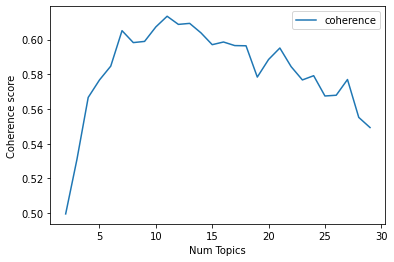

In [50]:
limit, start, step = 30, 2, 1
x = range(start, limit, step)
plt.plot(x, coherence_values, label='coherence')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(loc='best')
plt.show()

In [51]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4996
Num Topics = 3  has Coherence Value of 0.531
Num Topics = 4  has Coherence Value of 0.5667
Num Topics = 5  has Coherence Value of 0.5768
Num Topics = 6  has Coherence Value of 0.5847
Num Topics = 7  has Coherence Value of 0.6052
Num Topics = 8  has Coherence Value of 0.5983
Num Topics = 9  has Coherence Value of 0.599
Num Topics = 10  has Coherence Value of 0.6073
Num Topics = 11  has Coherence Value of 0.6135
Num Topics = 12  has Coherence Value of 0.6088
Num Topics = 13  has Coherence Value of 0.6094
Num Topics = 14  has Coherence Value of 0.6039
Num Topics = 15  has Coherence Value of 0.5971
Num Topics = 16  has Coherence Value of 0.5986
Num Topics = 17  has Coherence Value of 0.5966
Num Topics = 18  has Coherence Value of 0.5965
Num Topics = 19  has Coherence Value of 0.5784
Num Topics = 20  has Coherence Value of 0.5886
Num Topics = 21  has Coherence Value of 0.5952
Num Topics = 22  has Coherence Value of 0.5845
Num Topics = 23  has Co

Print top words for the best model

In [52]:
optimal_model = model_list[10]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.062*"agricultur" + 0.047*"forest" + 0.041*"land" + 0.040*"product" + '
  '0.033*"sector" + 0.033*"area" + 0.020*"forestri" + 0.015*"includ" + '
  '0.014*"reduc" + 0.014*"cover"'),
 (1,
  '0.112*"energi" + 0.030*"gener" + 0.029*"effici" + 0.027*"transport" + '
  '0.027*"electr" + 0.026*"wast" + 0.025*"renew" + 0.022*"industri" + '
  '0.019*"sourc" + 0.018*"power"'),
 (2,
  '0.067*"project" + 0.034*"includ" + 0.033*"base" + 0.032*"report" + '
  '0.027*"data" + 0.025*"inform" + 0.023*"approach" + 0.020*"monitor" + '
  '0.020*"assess" + 0.018*"avail"'),
 (3,
  '0.064*"water" + 0.051*"manag" + 0.044*"resourc" + 0.031*"system" + '
  '0.026*"improv" + 0.024*"protect" + 0.023*"infrastructur" + 0.023*"health" + '
  '0.022*"natur" + 0.020*"disast"'),
 (4,
  '0.036*"support" + 0.030*"technolog" + 0.026*"capac" + 0.023*"build" + '
  '0.022*"intern" + 0.022*"institut" + 0.021*"govern" + 0.021*"financ" + '
  '0.019*"financi" + 0.019*"fund"'),
 (5,
  '0.067*"countri" + 0.037*"econom" + 0.03

In [54]:
optimal_model = convertldaGenToldaMallet(optimal_model)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:236: RuntimeWarning: divide by zero encountered in log
  log_1 = np.log(pd.eval("(topic_given_term.T / topic_proportion)"))
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:259: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(pd.eval("topic_term_dists / term_proportion")).astype("float64")
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:260: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists).astype("float64")


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
11    -0.185353  0.210863       1        1  8.993087
5     -0.007174  0.127913       2        1  8.749079
4      0.156473 -0.181101       3        1  8.607582
10     0.255629 -0.086689       4        1  8.522933
8      0.014479 -0.078078       5        1  8.459342
7     -0.074062  0.257932       6        1  8.441572
6      0.151035 -0.003168       7        1  8.259992
9      0.217281  0.126156       8        1  8.243989
1     -0.208223 -0.108212       9        1  8.158179
3     -0.133321 -0.254642      10        1  7.981164
0     -0.226670 -0.104123      11        1  7.877992
2      0.039906  0.093148      12        1  7.705089, topic_info=        Term         Freq        Total Category  logprob  loglift
110   climat  7028.000000  7028.000000  Default  30.0000  30.0000
109    chang  5442.000000  5442.000000  Default  29.0000  29.0000
181    emiss  4232.000000  4232.000000  Default  28.0000  28.0000
43    nation  4662.000000  4662.000000  Default  27.0000  27.0000
9     energi  3326.000000  3326.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
302    relev   233.951836   464.902105  Topic12  -4.7837   1.8766
424   period   253.630030   689.438684  Topic12  -4.7029   1.5633
333  current   262.375882   821.721993  Topic12  -4.6690   1.4217
544   regard   214.273642   377.255468  Topic12  -4.8715   1.9976
369   system   214.273642  1323.289222  Topic12  -4.8715   0.7427

[862 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2755      5  0.994490     abil
852       2  0.998312  acceler
100       1  0.056094   accord
100       6  0.396275   accord
100       8  0.548271   accord
...     ...       ...      ...
177      10  0.001704     year
415       2  1.001977    yemen
178      11  1.005301    yield
1675      2  0.993452  zimbabw
1155      1  1.000067     zone

[1077 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 6, 5, 11, 9, 8, 7, 10, 2, 4, 1, 3])

Compute dominant topic for each document

In [75]:
def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame()

    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            # dominant topic
            if j == 0: 
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break

    contents = df.NDC
    document = df.Document
    sent_topics_df = pd.concat([sent_topics_df, contents, document], axis=1)
    sent_topics_df.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Document']

    return(sent_topics_df)

In [76]:
df_dominant_topic = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df.NDC)

df_dominant_topic

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Document
0,1.0,0.1644,"energi, gener, effici, transport, electr, wast...",Cabo Verde is committed to implement the Susta...,../txts/CPV_Cabo-Verde_First_NDC_English_Parag...
1,6.0,0.1828,"mitig, implement, sector, measur, action, requ...",This updated NDC updates and strengthens the f...,../txts/RWA_Rwanda_First_NDC_English_Paragraph...
2,3.0,0.1772,"water, manag, resourc, system, improv, protect...",Gambia Watershed by a) Improving disaster prep...,../txts/GMB_Gambia_First_NDC_English_Paragraph...
3,6.0,0.1425,"mitig, implement, sector, measur, action, requ...",The estimated cost to reach the 14 target is t...,../txts/JOR_Jordan_First_NDC_English_Paragraph...
4,9.0,0.1348,"contribut, nation, ndc, commit, agreement, det...","Moreover, national efforts to implement INDC i...",../txts/FSM_Micronesia_First_NDC_English_Parag...
...,...,...,...,...,...
10817,11.0,0.1379,"increas, temperatur, flood, year, due, drought...",conducting surveillance and research on waterb...,../txts/KHM_Cambodia_First_NDC_English_Paragra...
10818,6.0,0.1220,"mitig, implement, sector, measur, action, requ...",The above chart contains a not exhaustive list...,../txts/URY_Uruguay_First_NDC_Translation_Engl...
10819,4.0,0.1615,"support, technolog, capac, build, intern, inst...","principles to be respected by the state, local...",../txts/MAR_Morocco_First_NDC_Translation_Engl...
10820,10.0,0.1977,"nation, develop, plan, polici, strategi, actio...",Integrated planning is the key means of implem...,../txts/LKA_Sri-Lanka_First_NDC_English_Paragr...


Show most representative documents for each topic

In [81]:
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_dominant_topic.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Topic_Perc_Contrib'], ascending=[0]).head(1)], 
                                            axis=0)

sent_topics_sorteddf_mallet

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Document
6831,0.0,0.4733,"agricultur, forest, land, product, sector, are...",paradigm that consists in adjusting the supply...,../txts/URY_Uruguay_First_NDC_Translation_Engl...
579,1.0,0.4413,"energi, gener, effici, transport, electr, wast...","In addition to gridbased clean power, distribu...",../txts/ARE_United-Arab-Emirates_Second_NDC_En...
4601,2.0,0.5606,"project, includ, base, report, data, inform, a...","11 IPCC, 2013 Summary for Policymakers. In Cli...",../txts/BRA_Brazil_First_NDC_English_Paragraph...
249,3.0,0.3458,"water, manag, resourc, system, improv, protect...",Thailands prioritized adaptation efforts inclu...,../txts/THA_Thailand_First_NDC_English_Paragra...
6102,4.0,0.4542,"support, technolog, capac, build, intern, inst...",4 The SNRCC operates at charge of the Ministry...,../txts/URY_Uruguay_First_NDC_Translation_Engl...
3464,5.0,0.4079,"countri, econom, develop, growth, economi, pop...","From another angle, the modest income levels o...",../txts/JOR_Jordan_First_NDC_English_Paragraph...
547,6.0,0.4024,"mitig, implement, sector, measur, action, requ...",3.1 Investment Requirements In the 10year peri...,../txts/GHA_Ghana_First_NDC_English_Paragraph5...
6879,7.0,0.4421,"emiss, ghg, reduct, ga, greenhous, estim, targ...",(corresponding to 2.6 reduction of total emiss...,../txts/JPN_Japan_First_NDC_English_Paragraph8...
2331,8.0,0.3491,"climat, chang, adapt, vulner, impact, resili, ...",current and ongoing national development polic...,../txts/DMA_Dominica_First_NDC_English_Paragra...
1690,9.0,0.5141,"contribut, nation, ndc, commit, agreement, det...",Submission by Iceland to the ADP Icelands Inte...,../txts/ISL_Iceland_First_NDC_English_Paragrap...


Compute aggregated data for each country

In [103]:
def compute_iso(document):
  pos = document.find('_')
  return document[(pos-3):pos]

In [109]:
def country_name(document):
  pos1 = document.find('_')
  pos2 = document.find('_', pos1+1)
  return document[pos1+1:pos2]

In [135]:
def doc_topic_distribution(ldamodel, corpus, df):
    topic_distr = pd.DataFrame()
    # percentages for each topic
    for row in ldamodel[corpus]:
        percentages = [perc for topic, perc in row]
        topic_distr = topic_distr.append(pd.Series(percentages), ignore_index=True)
    # add original text, doc name, country name and ISO
    contents = df.NDC
    document = df.Document
    iso = df.Document.apply(compute_iso)
    country = df.Document.apply(country_name)

    topic_distr = pd.concat([topic_distr, contents, document, iso, country], axis=1)
    columns = [str(x) for x in range(12)]
    columns.extend(['Text', 'Document', 'ISO', 'Country'])
    topic_distr.columns = columns

    return topic_distr

Compute distribution of topics in each paragraph

In [138]:
distr_df = doc_topic_distribution(optimal_model, corpus, df)
distr_df

,0,1,2,3,4,5,6,7,8,9,10,11,Text,Document,ISO,Country
0,0.056906,0.164414,0.056306,0.064330,0.089584,0.057868,0.064139,0.069820,0.062858,0.083898,0.141880,0.087996,Cabo Verde is committed to implement the Susta...,../txts/CPV_Cabo-Verde_First_NDC_English_Parag...,CPV,Cabo-Verde
1,0.054304,0.046105,0.156100,0.058654,0.080736,0.054706,0.182793,0.063483,0.056152,0.130133,0.071436,0.045397,This updated NDC updates and strengthens the f...,../txts/RWA_Rwanda_First_NDC_English_Paragraph...,RWA,Rwanda
2,0.071764,0.072196,0.070634,0.177184,0.087571,0.070621,0.070728,0.073471,0.079868,0.070621,0.070621,0.084721,Gambia Watershed by a) Improving disaster prep...,../txts/GMB_Gambia_First_NDC_English_Paragraph...,GMB,Gambia
3,0.061275,0.062224,0.061275,0.076000,0.061275,0.108658,0.142537,0.136371,0.061564,0.099174,0.061275,0.068374,The estimated cost to reach the 14 target is t...,../txts/JOR_Jordan_First_NDC_English_Paragraph...,JOR,Jordan
4,0.062194,0.069335,0.062189,0.074378,0.081125,0.086128,0.109306,0.086685,0.076546,0.134848,0.095077,0.062189,"Moreover, national efforts to implement INDC i...",../txts/FSM_Micronesia_First_NDC_English_Parag...,FSM,Micronesia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10817,0.070621,0.070621,0.090928,0.092508,0.087571,0.070621,0.070621,0.070621,0.096733,0.070621,0.070621,0.137910,conducting surveillance and research on waterb...,../txts/KHM_Cambodia_First_NDC_English_Paragra...,KHM,Cambodia
10818,0.085037,0.076667,0.083668,0.074611,0.073403,0.077089,0.121952,0.095584,0.070621,0.078299,0.083262,0.079806,The above chart contains a not exhaustive list...,../txts/URY_Uruguay_First_NDC_Translation_Engl...,URY,Uruguay
10819,0.057739,0.072599,0.069743,0.064845,0.161533,0.075059,0.068614,0.057078,0.088540,0.092932,0.119764,0.071554,"principles to be respected by the state, local...",../txts/MAR_Morocco_First_NDC_Translation_Engl...,MAR,Morocco
10820,0.080692,0.083176,0.062919,0.071681,0.064438,0.070976,0.085844,0.063617,0.078482,0.062189,0.197728,0.078258,Integrated planning is the key means of implem...,../txts/LKA_Sri-Lanka_First_NDC_English_Paragr...,LKA,Sri-Lanka


In [144]:
distr_df.to_csv("topic_distr.csv")

Compute aggregated topic distribution for each country

In [141]:
agg_df = distr_df.drop(columns=['Text', 'Document', 'Country'])
agg_df

,0,1,2,3,4,5,6,7,8,9,10,11,ISO
0,0.056906,0.164414,0.056306,0.064330,0.089584,0.057868,0.064139,0.069820,0.062858,0.083898,0.141880,0.087996,CPV
1,0.054304,0.046105,0.156100,0.058654,0.080736,0.054706,0.182793,0.063483,0.056152,0.130133,0.071436,0.045397,RWA
2,0.071764,0.072196,0.070634,0.177184,0.087571,0.070621,0.070728,0.073471,0.079868,0.070621,0.070621,0.084721,GMB
3,0.061275,0.062224,0.061275,0.076000,0.061275,0.108658,0.142537,0.136371,0.061564,0.099174,0.061275,0.068374,JOR
4,0.062194,0.069335,0.062189,0.074378,0.081125,0.086128,0.109306,0.086685,0.076546,0.134848,0.095077,0.062189,FSM
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10817,0.070621,0.070621,0.090928,0.092508,0.087571,0.070621,0.070621,0.070621,0.096733,0.070621,0.070621,0.137910,KHM
10818,0.085037,0.076667,0.083668,0.074611,0.073403,0.077089,0.121952,0.095584,0.070621,0.078299,0.083262,0.079806,URY
10819,0.057739,0.072599,0.069743,0.064845,0.161533,0.075059,0.068614,0.057078,0.088540,0.092932,0.119764,0.071554,MAR
10820,0.080692,0.083176,0.062919,0.071681,0.064438,0.070976,0.085844,0.063617,0.078482,0.062189,0.197728,0.078258,LKA


In [142]:
agg_df.groupby('ISO').mean()

,0,1,2,3,4,5,6,7,8,9,10,11
ISO,,,,,,,,,,,,
AFG,0.089193,0.087936,0.074655,0.085251,0.087953,0.095501,0.073487,0.088145,0.086909,0.069167,0.087097,0.074706
AGO,0.095501,0.095148,0.073970,0.073567,0.071957,0.075459,0.095984,0.118268,0.084142,0.068431,0.073505,0.074068
ALB,0.077755,0.078460,0.081850,0.079194,0.081094,0.083607,0.084700,0.090237,0.079190,0.099684,0.084467,0.079762
ARE,0.068773,0.150457,0.064904,0.097927,0.091598,0.083609,0.072261,0.071589,0.071149,0.073261,0.081236,0.073238
ARG,0.067302,0.061397,0.101999,0.079884,0.089858,0.065115,0.084314,0.095788,0.078853,0.127417,0.070796,0.077275
...,...,...,...,...,...,...,...,...,...,...,...,...
WSM,0.075442,0.095320,0.078222,0.076633,0.080873,0.084070,0.084293,0.090535,0.082697,0.087392,0.086817,0.077707
YEM,0.075174,0.081827,0.075146,0.082771,0.075787,0.107956,0.083006,0.083389,0.096581,0.062597,0.068323,0.107442
ZAF,0.057788,0.069058,0.082881,0.065421,0.076566,0.084909,0.127225,0.107690,0.081252,0.100671,0.074196,0.072345


In [143]:
agg_df.to_csv("aggregated_data.csv")